In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
import sys

p = Path('.').resolve()
sys.path.append(str(p.parent))

In [2]:
from utils.data_utils import *
from utils.faiss_utils import *

Loading faiss with AVX2 support.


In [3]:
def load_XY(basename):
    """
    Load embeddings (X) and possibly the
    labels (Y) of the graph {basename}.
    """
    model_path = Path("/data/models") / basename
    print("Loading data..")
    X, Y = load_data(model_path)
    classes = len(np.unique(Y))
    print("X shape: {}".format(X.shape))
    return X, Y

In [4]:
def iter_embeddings(model_path, h5=True):
    """
    updated version of iter_partitions
    NOTICE: returns objects NOT ordered
    """
    temp = []
    if h5:
        for h5_file in model_path.glob('embeddings_link*.h5'):
            temp.append(h5_file)
    else:
        for json_file in model_path.glob('entity_names_link_*.json'):
            temp.append(json_file)
    temp = sorted(temp)
    for i in temp:
        yield i

In [5]:
import json


def get_entities_list(basename):
    entities_list = []
    model_path = Path("/data/models") / basename
    for json_f in iter_embeddings(model_path, h5=False):
        with json_f.open() as f:
            # with open(json_f, "rt") as f:
            entities = json.load(f)
        entities_list += [int(i) for i in entities]
    return entities_list

In [6]:
basename = "enwiki-2016"
x, y = load_XY(basename)
x.shape

Loading data..
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
Labels not defined
X shape: (5088560, 128)


(5088560, 128)

In [7]:
enwiki_kmeans = kmeans(x, 50, niter=10000)

In [8]:
entities = get_entities_list(basename)
centroid_neigh("enwiki-2016", enwiki_kmeans, x, entities, n=5)

 Cluster 0 
Arthur Randall

Second Battle of Heligoland Bight

HMS Calcutta (D82)

Vincent Barkly Molteno

Battle of Crete order of battle

 Cluster 1 
Load balancing (computing)

Application layer

Simple Network Management Protocol

Continuous delivery

Data recovery

 Cluster 2 
Instrument (To Rococo Rot album)

Change of Skin

Serpentine Gallery (album)

The Party Scene

Everybody Knows (The Young Gods album)

 Cluster 3 
2012 Hathazari violence

List of places in Peshawar

Bengali Language Movement

Chaudhry Niaz Ali Khan

Chichawatni

 Cluster 4 
The Line of Beauty (TV series)

Judy Loe

Victoria Wood As Seen On TV

The Go-Between (2015 TV film)

Shoestring (TV series)

 Cluster 5 
Rest frame

Pugh–Schiff precession

Clock-comparison experiment

AQUAL

N-body simulation

 Cluster 6 
Texas A&M Aggies softball

List of Southeastern Conference national championships

Joe Bauserman

Rollie Seltz

Western Carolina Catamounts

 Cluster 7 
Sciotropis

Crocyllis

Hypolestes

Dioicodendro

# Build categories dictionary

In [9]:
cat_file = Path("/data/graphs") / basename / "page2cat.tsv"
cat_file.exists()

True

In [10]:
from collections import defaultdict


def buildCategoryDict(catFile):
    """
    
    """
    categories = defaultdict(set)
    for pos, line in enumerate(catFile.open(encoding="utf-8")):
        temp = line.rstrip().split("\t")
        key, cat = temp[0], set(temp[1:])
        categories[key] = cat
    return categories

In [11]:
categs = buildCategoryDict(cat_file)

In [12]:
for pos, key in enumerate(categs):
    print(key)
    if pos > 20:
        break

Anarchism
Değnek
Queensland Conservatorium Griffith University
Octagon Chapel, Liverpool
Radha Mohan
Thomas Craig (jurist)
Microsorum vieillardii
Princess Augusta Sophia of the United Kingdom
Derek Thompson (baseball)
Battle of the Coral Sea (film)
Carvone
Red-tailed monkey
2003 MAC Men's Basketball Tournament
Louis Franchet d'Espèrey
Benjamin Tuke
Cornelis de Bie
Washington State Legislature
Đàn đá
Issa (Senegalese singer)
William Johnston Tupper
Saint Vincent Academy
Bonkers (song)


In [13]:
len(categs)

3726309

In [14]:
def jaccard_sim(s1, s2):
    assert type(s1) == type(s2) == set, "only taking sets as input"
    return len(s1 & s2) / len(s1 | s2)


s1 = set([1, 2, 3])
s2 = set([3, 4, 5])
jaccard_sim(s1, s2)

0.2

What is the percentage of pages embedded contained in the categories dataset?

In [15]:
ids_file = Path('/data/graphs/') / basename / (basename + '.ids')
counter = 0
for pos, line in enumerate(ids_file.open(encoding="utf-8")):
    if line.rstrip() in categs:
        counter += 1
        
counter / pos

0.7300073033577786

# Link to categories

In [16]:
from itertools import combinations
from scipy.spatial.distance import pdist



def get_id(basename, idx, ent_list):
    ids_file = Path('/data/graphs/') / basename / (basename + '.urls')
    if not ids_file.exists():
        ids_file = Path('/data/graphs/') / basename / (basename + '.ids')
    assert ids_file.exists(), "File not found!"
    f = ids_file.as_posix()
    for node in idx:
        line = ent_list[node]
        yield linecache.getline(f, line + 1).rstrip()


def jaccard_sim(s1, s2):
    assert type(s1) == type(s2) == set, "only taking sets as input"
    return len(s1 & s2) / len(s1 | s2)


def jaccard_vs_distance(x, categories, entities, n=100):
    """
    
    """
    subset = np.random.choice(len(x), n, replace=False)
    ids = [i for i in get_id("enwiki-2016", subset, entities)]
    # polishing
    print("Removing nodes not contained in the categories dictionary..")
    indices = []
    for pos, value in enumerate(ids):
        if value in categories:
            if len(categories[value]) > 0:
                indices.append(pos)

    ids = [ids[i] for i in indices]
    subset = [subset[i] for i in indices]
    print("Effective number of nodes: {}".format(len(ids)))
    # compute
    jaccard_scores = [jaccard_sim(categories[i[0]], categories[i[1]]) for i in combinations(ids, 2)]
    dist = pdist(x[subset], 'euclidean')
    return np.array(jaccard_scores), dist, ids

# N = 100

In [17]:
js, eu_dist, ids = jaccard_vs_distance(x, categs, entities)

Removing nodes not contained in the categories dictionary..
Effective number of nodes: 71


Text(0, 0.5, 'Jaccard sym')

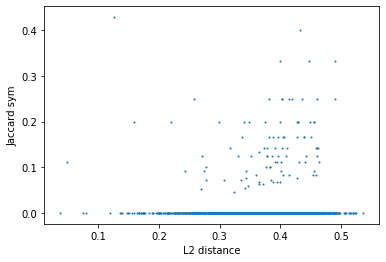

In [18]:
plt.scatter(eu_dist, js, s=1)
plt.xlabel("L2 distance")
plt.ylabel("Jaccard sym")

# N = 1000

In [19]:
js, eu_dist, ids = jaccard_vs_distance(x, categs, entities, n=1000)

Removing nodes not contained in the categories dictionary..
Effective number of nodes: 651


Text(0, 0.5, 'Jaccard sym')

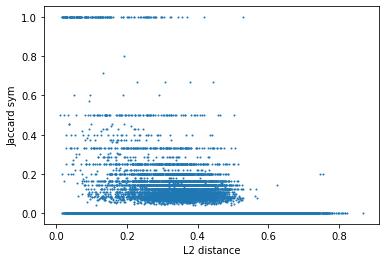

In [20]:
plt.scatter(eu_dist, js, s=1)
plt.xlabel("L2 distance")
plt.ylabel("Jaccard sym")

Let's check what are the outliers in the upper right part of the plot.

In [21]:
def outliersUpperRight(scores, dist, ids, categs, t1, t2):
    ind = np.where((dist >= t1) & (scores >= t2))[0]
    for pos, value in enumerate(combinations(ids, 2)):
        if pos in ind:
            print(value, dist[pos])
            print(categs[value[0]])
            print(categs[value[1]])
            print()

In [22]:
outliersUpperRight(js, eu_dist, ids, categs, 0.25, 0.8)

('Castelmoron-sur-Lot', 'Méréaucourt') 0.25151606042398095
{'Communes in France by department'}
{'Communes in France by department'}

('History of Red Star Belgrade', 'FC Barcelona C') 0.3245665955730762
{'Association football clubs by country'}
{'Association football clubs by country'}

('History of Red Star Belgrade', 'Al-Taka SC') 0.5289037722361197
{'Association football clubs by country'}
{'Association football clubs by country'}

('History of Red Star Belgrade', 'Bali United F.C.') 0.36892746342579796
{'Association football clubs by country'}
{'Association football clubs by country'}

('Hamouro', 'São João do Pacuí') 0.2971357314644847
{'Populated places by country'}
{'Populated places by country'}

('Clarkedale, Arkansas', '2001 Myrtle Beach tornadoes') 0.2739769998169712
{'Cities in the United States by state'}
{'Cities in the United States by state'}

('Clarkedale, Arkansas', 'Dyer, Tennessee') 0.2534565220876234
{'Cities in the United States by state'}
{'Cities in the United 

Let's check what are the outliers in the lower left part of the plot.

In [42]:
def outliersLowerLeft(scores, dist, ids, categories, t1, t2):
    ind = np.where((dist <= t1) & (scores <= t2))[0]
    for pos, value in enumerate(combinations(ids, 2)):
        if pos in ind:
            print("Node 1: {} - {}".format(value[0], categories[value[0]]))
            print("Node 2: {} - {}".format(value[1], categories[value[1]]))
            print("Distance: {0:.2f}".format(dist[pos]))
            print("Jaccard similarity: {}:".format(scores[pos]))
            print()

In [43]:
outliersLowerLeft(js, eu_dist, ids, categs, 0.05, 0.1)

Node 1: Gol Gol-e Sofla, Lorestan - {'Fifth-level administrative country subdivisions'}
Node 2: Méréaucourt - {'Communes in France by department'}
Distance: 0.05
Jaccard similarity: 0.0:

Node 1: Gol Gol-e Sofla, Lorestan - {'Fifth-level administrative country subdivisions'}
Node 2: Al-Taka SC - {'Association football clubs by country'}
Distance: 0.05
Jaccard similarity: 0.0:

Node 1: Gol Gol-e Sofla, Lorestan - {'Fifth-level administrative country subdivisions'}
Node 2: National Black Family Reunion - {'American culture by ethnicity', 'Family'}
Distance: 0.05
Jaccard similarity: 0.0:

Node 1: Soul Inspiration - {'Works by decade', 'Songs by songwriter'}
Node 2: Beyond the Pale (Fiona album) - {'Pop rock albums by American artists', 'Albums by producer'}
Distance: 0.04
Jaccard similarity: 0.0:

Node 1: Soul Inspiration - {'Works by decade', 'Songs by songwriter'}
Node 2: Forget About It - {'Country albums by American artists'}
Distance: 0.05
Jaccard similarity: 0.0:

Node 1: Cheshmeh-y

Node 1: The River (Garth Brooks song) - {'Country music', 'Songs by songwriter', 'Products by company', 'American country music songs', 'Works by decade', 'Song recordings by producer'}
Node 2: Forget About It - {'Country albums by American artists'}
Distance: 0.03
Jaccard similarity: 0.0:

Node 1: Al-Taka SC - {'Association football clubs by country'}
Node 2: Brancaccio (surname) - {'Italian language'}
Distance: 0.03
Jaccard similarity: 0.0:

Node 1: Al-Taka SC - {'Association football clubs by country'}
Node 2: Łyczyn, Greater Poland Voivodeship - {'Villages by country'}
Distance: 0.03
Jaccard similarity: 0.0:

Node 1: Al-Taka SC - {'Association football clubs by country'}
Node 2: Inga carinata - {'Flora by country', 'Rosids', 'Plants'}
Distance: 0.03
Jaccard similarity: 0.0:

Node 1: Al-Taka SC - {'Association football clubs by country'}
Node 2: Cui Shenji - {'Chinese people by occupation'}
Distance: 0.03
Jaccard similarity: 0.0:

Node 1: Al-Taka SC - {'Association football clubs by

Node 1: Zero Kilometre Stone - {'Capitals in Europe', 'Transport in Europe', 'Geodesy', 'Individual physical objects', 'Streets'}
Node 2: 1875 in South Africa - {'Years by country', '1870s by country'}
Distance: 0.05
Jaccard similarity: 0.0:



# Sampling couples of points

In [75]:
def couplesPlot(x, entities,  n=10e5, save=False):
    n = int(n)
    subset = np.random.choice(len(x), n, replace=True)
    ids = [i for i in get_id("enwiki-2016", subset, entities)]
    # polishing
    print("Removing nodes not contained in the categories dictionary..")
    indices = []
    for pos, value in enumerate(ids):
        if value in categs:
            if len(categs[value]) > 0:
                indices.append(pos)
    # need an even number for couples
    if len(indices) % 2 == 1:
        indices = indices[:-1]
    ids = [ids[i] for i in indices]
    x_subset = [x[subset[i]] for i in indices]
    m = len(ids) // 2
    print("Effective number of couples: {}".format(m))
    # compute
    jaccard_scores = [0] * m
    dist = [0] * m
    for i in range(m):
        jaccard_scores[i] = jaccard_sim(categs[ids[i]], categs[ids[i + 1]])
        dist[i] = np.linalg.norm(x_subset[i] - x_subset[i + 1])
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_title("{} nodes".format(m), fontsize=20)
    plt.scatter(dist, jaccard_scores, s=1)
    ax.set_ylabel('Jaccard similarity', fontsize=20)
    ax.set_xlabel('L2 distance', fontsize=20)
    if save:
        plt.savefig('js_vs_eudist.png', dpi=200)
    plt.show()

Removing nodes not contained in the categories dictionary..
Effective number of couples: 312884


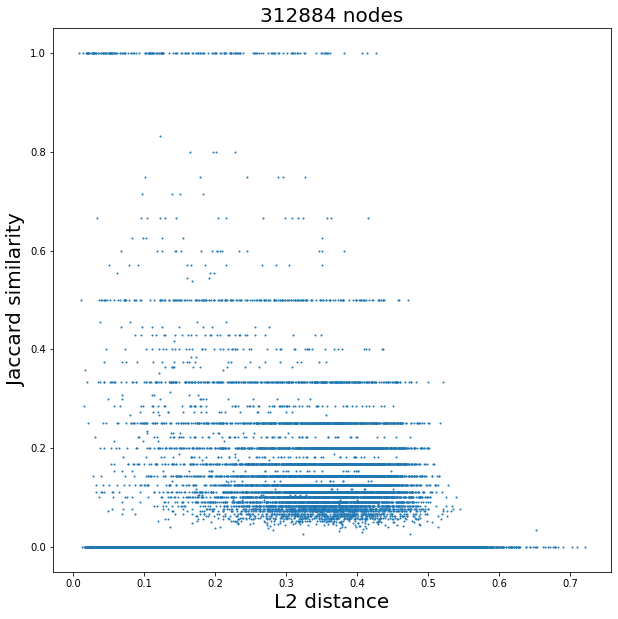

In [76]:
couplesPlot(x, entities, n=10e5)